<a href="https://colab.research.google.com/github/JhonJRB/Ciencia_Datos/blob/main/Proyecto_final_Rodriguez_Figueredo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendimiento del problema

**Contexto**

El objetivo de este analisis es determinar el patron/variable que conlleva a los usuarios de la aerolinea  a estar o no satisfechos con el servicio recibido.  Se intentara responder las siguientes hipotesis/preguntas:
- El genero es una variable que influye en la satisfaccion del cliente?
- Las horas de vuelo tienen incidencia en la satisfaccion de cliente?
- La clase en la que vuelen sera un factor importante en la satisfaccion, a mejor clase mayor satisfacción?
- Existe un servicio que determine directamente la satisfacion o no del cliente?

**Abstract:**

En el siguiente proyecto presentamos el dataset "Flights" con 23 variables y analiza mas de 100.000 viajeros aereos. Cuenta con variables de identificacion de los mismos como: el genero, que tipo de consumidor es (si cuenta con membresia Loyal o Disloyal), edad, motivo de viaje (viaje personal o por trabajo), el tipo de clase en la cual viajo (Eco, Eco Plus o Business) y la distancia del vuelo.
El mismo dataset tambien cuenta con una encuesta de satisfacción con puntajes del 0 al 5 en donde el viajero evalua los siguientes aspectos:
- Servicio de Wifi abordo
- Conveniencia del tiempo de arribo o partida del vuelo
- Facilidad al reservar de forma Online
- Ubicación de la puerta del vuelo
- Comida y bebida
- Abordaje del vuelo
- Comodidad del asiento
- Entretenimiento dentro del vuelo
- Servicio de abordaje al vuelo
- Espacio entre asientos (leg room)
- Manejo de equipaje
- Servicio de Check-in
- Servicio dentro del vuelo
- Limpieza

**Audiencia:** Aerolinea


# Extracción de datos

## Importe de liberias

In [ ]:
import pandas as pd #manipulacion de dataframe
import numpy as np #manipular arreglos (array)
import matplotlib.pyplot as plt #visualizaciones
import re # reemplazar espacios de las variables del dataset
import seaborn as sns #visualizaciones
import statsmodels.api as sm 
from sklearn import metrics # modulo para evaluar metricas del modelo
from sklearn.ensemble import RandomForestClassifier #Algoritmo para clasificacion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split #separar datos para test y train
from sklearn.preprocessing import StandardScaler #para escalado de datos
from sklearn.model_selection import cross_val_score #metodo cross validation
from sklearn.preprocessing import LabelEncoder # nos permite convertir las variables categorias a numeros, (Gender M/F a 0/1)
from sklearn.model_selection import GridSearchCV #mejorado de modelo, varias hyperparameters
from sklearn.model_selection import cross_val_score #visualizar resultados de aplicar CV
from sklearn.model_selection import KFold # validacion Kfold

## Importe de dataset via API

 (Es necesario tener en nuestra carpeta el token kaggle.json)

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory
!kaggle datasets download -d teejmahal20/airline-passenger-satisfaction #ir a Kaggle y presionar en (...) luego Copy API command
!unzip /content/airline-passenger-satisfaction.zip #descomprimir archivo
df=pd.read_csv('train.csv') #Generamos el dataframe a partir del csv


-rw-r--r-- 1 root root 70 Apr 12 17:44 kaggle.json
/content
 74% 2.00M/2.71M [00:00<00:00, 2.83MB/s]
100% 2.71M/2.71M [00:00<00:00, 3.16MB/s]
Archive:  /content/airline-passenger-satisfaction.zip
  inflating: test.csv                
  inflating: train.csv               


# Limpieza de datos

## Detección de valores nulos

In [ ]:
pd.set_option("display.max_rows",None)
df_nulos=df.isnull().sum().sort_values(ascending=False)
df_nulos[df_nulos>0] 

Arrival Delay in Minutes    310
dtype: int64

## Detección de valores duplicados

In [ ]:
df_dup=(df.duplicated() == True).sum()
df_dup

0

## Gestion de valores faltantes

Comenzamos eliminando las columnas que no son utiles para el analisis en cuestion, y convertimos las propiedades de los datos desde integer a variables categoricas. De los 310 datos nulos antes presentados de la variable " Arrival Delay in Minutes" se reemplazaran por su media correspondiente, siendo la misma de 15.1786.

Dado que no existen valores duplicados no se aplican cambios y se modifican los espacios en blanco de las variables por el caracter "_", concluyendo asi el manejo de datos faltantes para comenzar el analisis descriptivo.

In [ ]:
df=df.drop(['Unnamed: 0','id'],axis=1) # Eliminar col Unnamed y id
l=[x for x in df.columns if x not in ['Age','Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes']]
df[l]=df[l].astype('category') #Convertir variables tipo int a category
avg_norm_loss = df['Arrival Delay in Minutes'].astype("float").mean(axis=0) #Imputacion de datos nulos ***
df['Arrival Delay in Minutes'].replace(np.nan, avg_norm_loss, inplace=True)

#Cambiamos los espacios de las variables del dataset por "_"
for i in df.columns: 
  a=re.sub(r"\s+","_",i)
  df.rename(columns={i:a},inplace=True) 


# EDA

## Analisis Descriptivo

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,103904,2,Female,52727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_Type,103904,2,Loyal Customer,84923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,103904.0,NaN,NaN,NaN,39.379706,15.114964,7.0,27.0,40.0,51.0,85.0
Type_of_Travel,103904,2,Business travel,71655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class,103904,3,Business,49665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flight_Distance,103904.0,NaN,NaN,NaN,1189.448375,997.147281,31.0,414.0,843.0,1743.0,4983.0
Inflight_wifi_service,103904.0,6.0,3.0,25868.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Departure/Arrival_time_convenient,103904.0,6.0,4.0,25546.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ease_of_Online_booking,103904.0,6.0,3.0,24449.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gate_location,103904.0,6.0,3.0,28577.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analisis Univariado

- V1 - Piechart: se plotea la distribución de las variables target ('satisfaction') y Genero

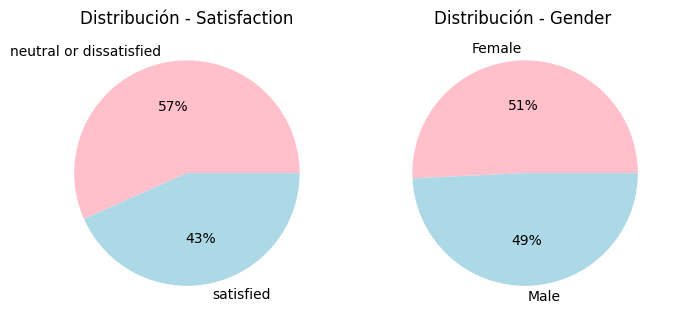

In [ ]:
df1=df['satisfaction'].value_counts()
df2=df['Gender'].value_counts()
plt.subplot(1,2,1)
df1.plot(kind='pie', title='Distribución - Satisfaction',figsize=(8,5),autopct='%.f%%',label='',colors=['pink','lightblue','red'])
plt.subplot(1,2,2)
df2.plot(kind='pie', title='Distribución - Gender ',figsize=(8,5),autopct='%.f%%',label='',colors=['pink','lightblue','red'])
plt.show()

## Analisis Bivariado


- V2 - barplot: Se busca determinar si el genero tiene incidencia sobre la satisfaccion del usuario

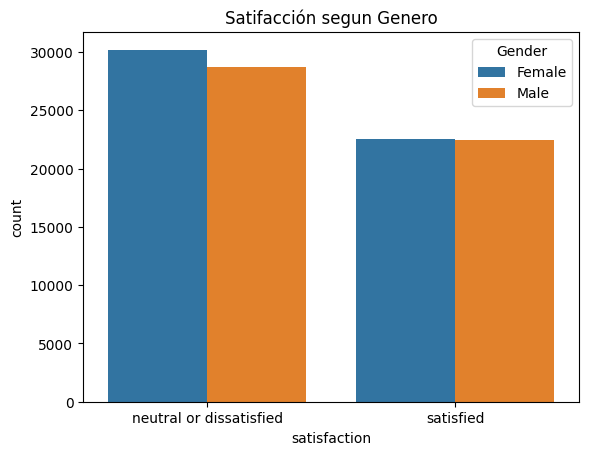

In [ ]:
sns.countplot(data=df.satisfaction, x=df.satisfaction, hue=df.Gender).set(title='Satifacción segun Genero')
plt.show()

- V3 - Boxplot: Se busca determinar si el tiempo de vuelo tienen incidencia en la satisfacion del usuario

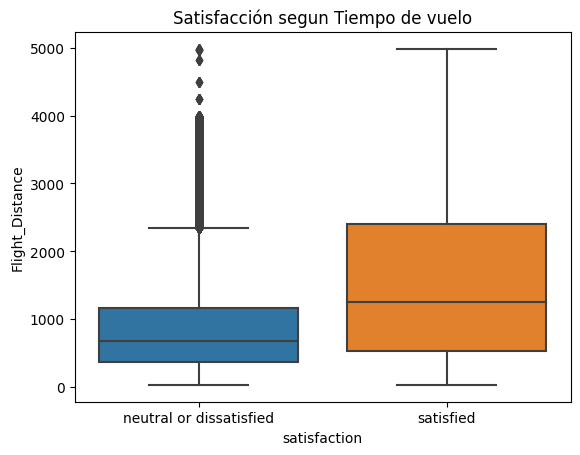

In [ ]:
sns.boxplot(data=df,y='Flight_Distance',x='satisfaction').set(title='Satisfacción segun Tiempo de vuelo')
plt.show()

- V4 - barplot: Se busca determinar si la variable Class tiene incidencia sobre la satisfaccion del usuario

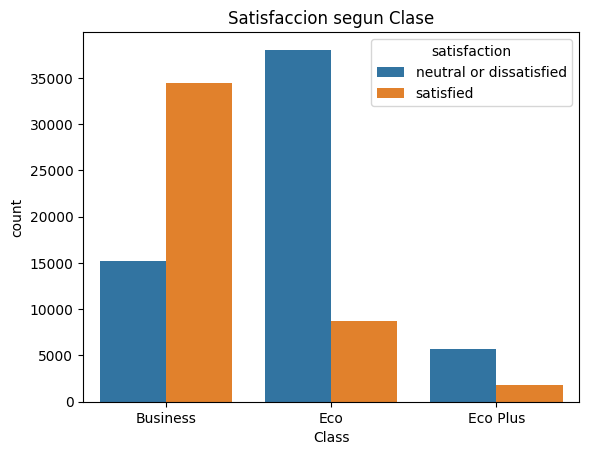

In [ ]:
sns.countplot(df.Class, x=df.Class, hue=df.satisfaction).set(title='Satisfaccion segun Clase')
plt.show()

## Analisis Multivariado

- V5 Pairplot, se realiza para saber si existe dependencia de una variable (numerica) con otra.

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been ass

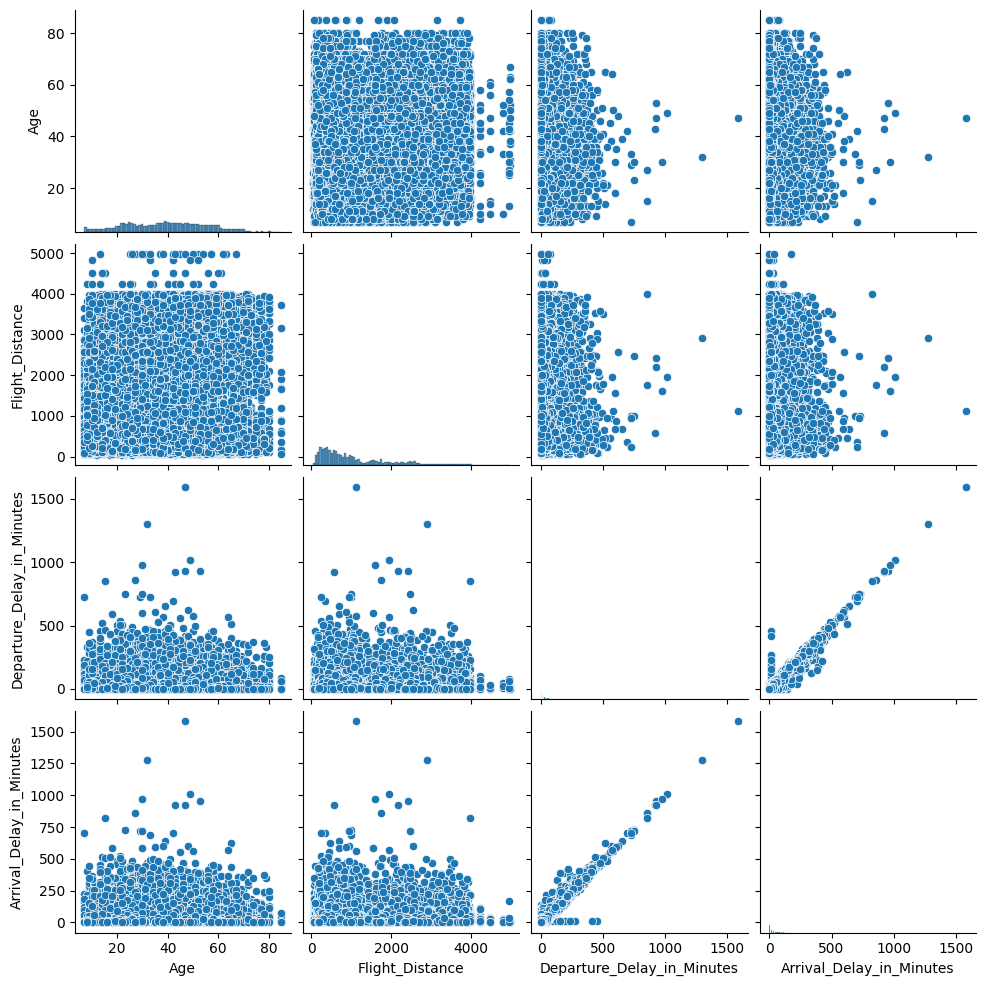

In [ ]:
sns.pairplot(df, palette='plasma')

## Conclusiones

- V1: La distribucion de la variable target "satisfaction" esta balanceado (Insatisfechos o Neutro 57%, Satisfechos 43%)
- V1: La distribucion de la variable "Gender" esta balanceada (51% Hombres, 49% mujeres)
- V2: No se observa incidencia del sexo sobre satisfaccion del cliente.
- V3: Se observa que a mayor tiempo de vuelo, el usuario suele estar mas satisfecho con el servicio.
- V4: Se observa una clara incidencia de la variable "Class" sobre la satisfaccion del usuario. Usuarios que viajan en clase "Business" suelen estar mayormente satisfechos, por el contrario los usuarios que viajen en clase "Eco class" suelen estar mayormente insatisfechos o neutro. 
- V5: Se observa dependencia de la variable Arrival_Delay_Minutes con respecto la variable Departure_Delay_in_Minutes, es decir si existe retardo en la salida la llegada tendra retardo.  

# Selección de variables

## Label Encoder

In [ ]:
#Convertimos las variables categoricas a numericas
df_categorico = df.select_dtypes(include = 'category')
le=LabelEncoder()
for col in df_categorico.columns:
    df[col] = le.fit_transform(df[col])

## Correlación de variables (heatmap)

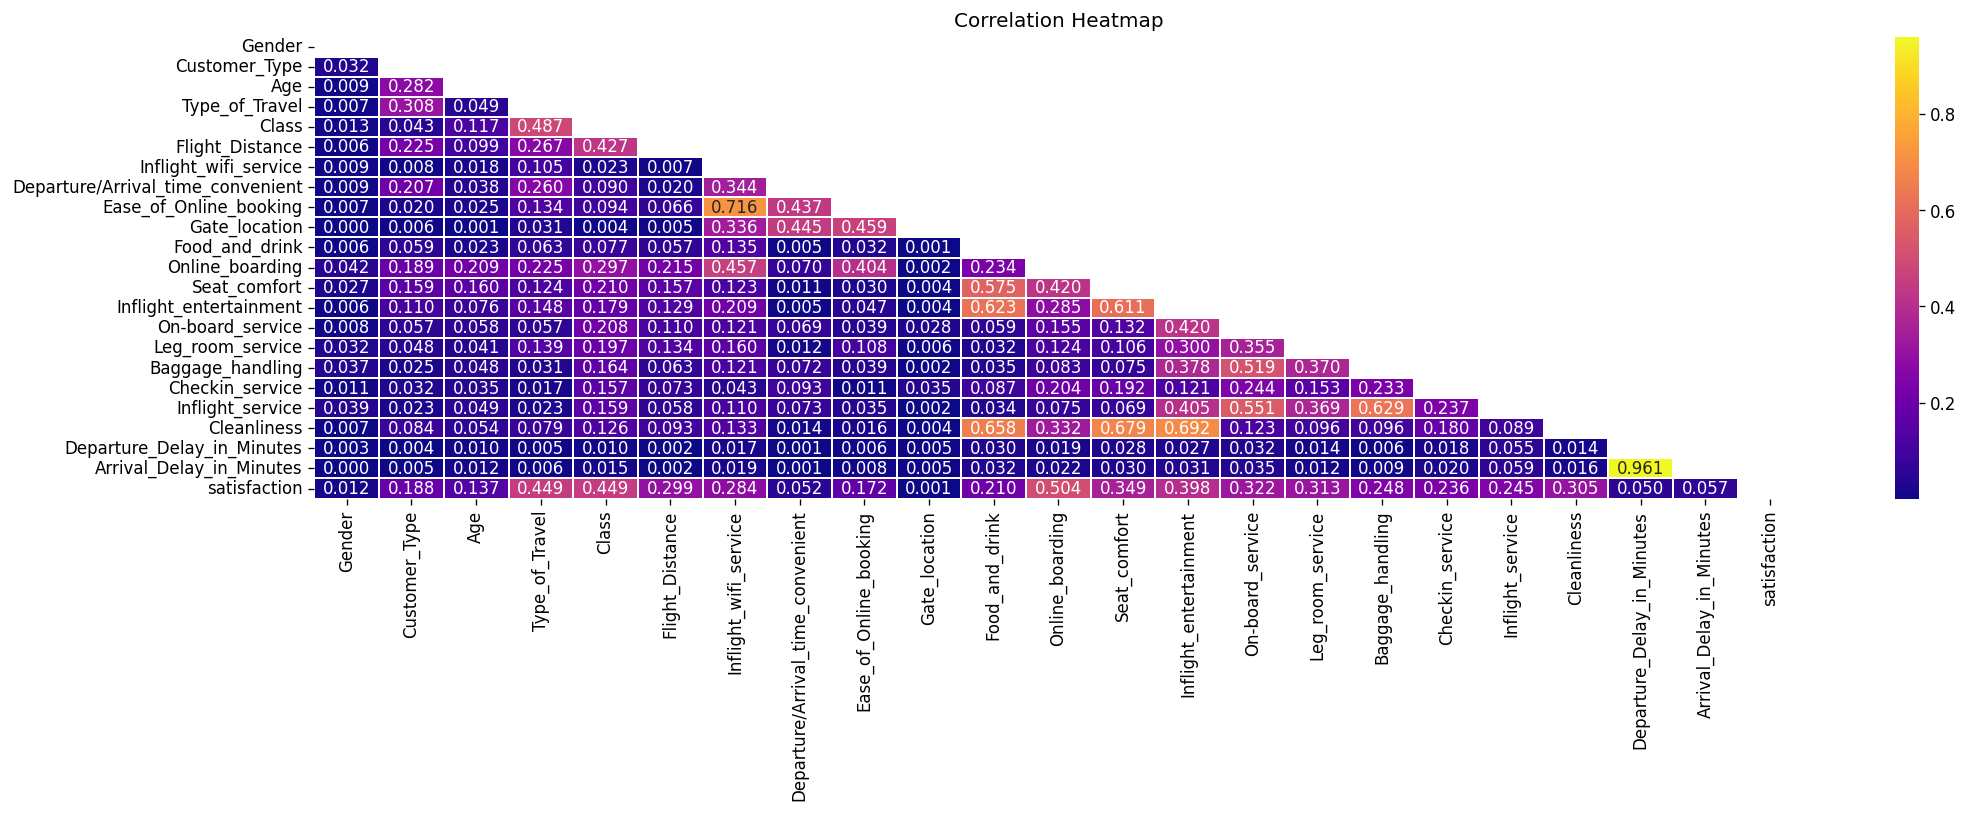

In [ ]:
plt.figure(dpi = 120,figsize= (20,5))
mask = np.triu(np.ones_like(abs(df.corr()),dtype = bool))
sns.heatmap(abs(df.corr()),mask = mask, fmt = ".3f",annot=True,lw=1,cmap = 'plasma')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

## Variables con menos correlación

In [ ]:
df_corre=(abs(df.corr()['satisfaction']))
df_corre=pd.DataFrame(df_corre[df_corre<0.09])
df_corre

,satisfaction
Gender,0.012211
Departure/Arrival_time_convenient,0.051601
Gate_location,0.000682
Departure_Delay_in_Minutes,0.050494
Arrival_Delay_in_Minutes,0.057497


## Eliminar variables de menos correlacion

In [ ]:
#Se eliminan variables de poca correlacion:
df=df.drop(['Gender','Departure/Arrival_time_convenient','Gate_location','Departure_Delay_in_Minutes','Arrival_Delay_in_Minutes'],axis=1)

# Modelamiento 

## Preparando datos para modelamiento

In [ ]:
#Separamos variable target - variable independientes
X=df.drop(['satisfaction'],axis=1)
y=df['satisfaction']
#Se aplica metodo get_dummies() a variables categoricas
X=pd.get_dummies(X, columns=['Customer_Type','Type_of_Travel','Class'])
#Se aplica label_enconder a la variable target
le=LabelEncoder()
y=le.fit_transform(df['satisfaction'])
#Aplicamos Scaler
scaler=StandardScaler()
X=scaler.fit_transform(X)
X=pd.DataFrame(X)

## RFC -> Validacion Simple

### Instanciando modelo

In [ ]:
#Separamos entre train y test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=12)
#Aplicamos modelo
rfc= RandomForestClassifier(random_state=12)
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)

### Metricas

In [ ]:
rfc_accuracy=metrics.accuracy_score(y_test,y_pred)
rfc_precision=metrics.precision_score(y_test,y_pred)
rfc_sensibilidad=metrics.recall_score(y_test,y_pred)
rfc_f1_score=metrics.f1_score(y_test,y_pred)

print('Exactitud:', rfc_accuracy)
print('Precision-recall:', rfc_precision)
print('Sensibilidad:',rfc_sensibilidad)
print('F1_score:',rfc_f1_score)

Exactitud: 0.9613104404065291
Precision-recall: 0.9724566447185384
Sensibilidad: 0.9367518313382169
F1_score: 0.9542703735723711


### Mejora - Hyperparameters

In [ ]:
rfc.get_params() #parametros de rfc

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12,
 'verbose': 0,
 'warm_start': False}

In [ ]:
parametros = {'max_depth':[10,20,30],'random_state':[12], 'n_estimators':[10,50]} #parametros 
grid= GridSearchCV(estimator=rfc,param_grid=parametros, scoring='accuracy',cv=3) #instanciar metodo
grid.fit(X_train,y_train) #se entrena
rfc_accuracy_gs=grid.best_score_ #mejor performance
rfc_accuracy_gs

0.9595524073503747

In [ ]:
grid.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=50, random_state=12)

## RFC -> K-Fold

###Instanciar Modelo

In [ ]:
rfc_kfold= RandomForestClassifier(random_state=12) #instaciamos modelo
rfc_cv_kfold= KFold() #instaciamos CV
rfc_score_kfold=cross_val_score(rfc_kfold,X,y, scoring='accuracy', cv=rfc_cv_kfold)

###Metricas

In [ ]:
rfc_accuracy_kfold=rfc_score_kfold.mean()
rfc_accuracy_kfold=rfc_score_kfold.mean()
rfc_varianza_kfold=rfc_score_kfold.var()
rfc_bias_kfold=(1-rfc_accuracy_kfold)**2
print(f'K-fold: {rfc_score_kfold}')
print(f'Accuracy con Kfold: {rfc_accuracy_kfold}')
print(f'Varianza: {rfc_varianza_kfold}')
print(f'Bias: {rfc_bias_kfold}')

K-fold: [0.96039652 0.96203263 0.960589   0.96333189 0.96323388]
Accuracy con Kfold: 0.9619167820016239
Varianza: 1.564981638589311e-06
Bias: 0.0014503314931118378


## KNN -> validacion Simple

### Instanciando modelo

In [ ]:
#Separamos entre train y test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=12)
#Aplicamos modelo
knn= KNeighborsClassifier() #KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)

### Metricas

In [ ]:
knn_acurracy=metrics.accuracy_score(y_test,y_pred)
knn_precision=metrics.precision_score(y_test,y_pred)
knn_sensibilidad=metrics.recall_score(y_test,y_pred)
knn_f1_score=metrics.f1_score(y_test,y_pred)

print('Exactitud:', knn_acurracy)
print('Precision-recall:', knn_precision)
print('Sensibilidad:',knn_sensibilidad)
print('F1_score:',knn_f1_score)

Exactitud: 0.9315137049584231
Precision-recall: 0.954172696575012
Sensibilidad: 0.8835090226907272
F1_score: 0.9174822579897026


### Tuning Hyperparameters

In [ ]:
knn.get_params() #parametros de knn

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
parametros = {'n_neighbors':[2,3,5,7], 'leaf_size':[10,20,30,50]} #parametros 
grid= GridSearchCV(knn, parametros, scoring='accuracy',cv=3) #instanciar metodo
grid.fit(X_train, y_train) #se entrena
knn_accuracy_gs=grid.best_score_ #mejor performance
knn_accuracy_gs

0.9303459603736782

In [ ]:
grid.best_estimator_

KNeighborsClassifier(leaf_size=10, n_neighbors=7)

## KNN -> K-Fold

###Instanciar Modelo

In [ ]:
knn_kfold= KNeighborsClassifier() #instaciamos modelo
knn_cv_kfold= KFold() #instaciamos CV
knn_score_kfold=cross_val_score(knn_kfold,X,y, scoring='accuracy', cv=knn_cv_kfold)

###Metricas

In [ ]:
knn_accuracy_kfold=knn_score_kfold.mean()
knn_varianza_kfold=knn_score_kfold.var()
knn_bias_kfold=(1-knn_accuracy_kfold)**2
print(f'K-fold: {knn_score_kfold}')
print(f'Accuracy con Kfold: {knn_accuracy_kfold}')
print(f'Varianza: {knn_varianza_kfold}')
print(f'Bias: {knn_bias_kfold}')

K-fold: [0.93060969 0.93123526 0.93219768 0.93166835 0.93498556]
Accuracy con Kfold: 0.932139309807642
Varianza: 2.2966799212773595e-06
Bias: 0.004605073273383189


## SVM -> Validacion Simple

### Instanciando modelo

In [ ]:
#Separamos entre train y test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=12)
#Aplicamos modelo
svm= SVC(random_state=12) #SVC(kernel='linear', C=1, random_state=0)
svm.fit(X_train, y_train)
y_pred=svm.predict(X_test)

### Metricas

In [ ]:
svm_acurracy=metrics.accuracy_score(y_test,y_pred)
svm_precision=metrics.precision_score(y_test,y_pred)
svm_sensibilidad=metrics.recall_score(y_test,y_pred)
svm_f1_score=metrics.f1_score(y_test,y_pred)

print('Exactitud:', svm_acurracy)
print('Precision-recall:', svm_precision)
print('Sensibilidad:',svm_sensibilidad)
print('F1_score:',svm_f1_score)

Exactitud: 0.9539190021558361
Precision-recall: 0.9594631859545915
Sensibilidad: 0.9324638199035198
F1_score: 0.9457708512662529


###Mejora - Hyperparameters

In [ ]:
svm.get_params() #parametros de svm

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 12,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
parametros = {'degree':[1,2,3],'random_state':[12]} #parametros 
grid= GridSearchCV(estimator=svm,param_grid=parametros, scoring='accuracy',cv=3) #instanciar metodo
grid.fit(X_train, y_train) #se entrena
svm_accuracy_gs=grid.best_score_ #mejor performance
svm_accuracy_gs

0.9508520685761215

In [ ]:
grid.best_estimator_

SVC(degree=1, random_state=12)

In [ ]:
grid.cv_results_['params']

[{'degree': 1, 'random_state': 12},
 {'degree': 2, 'random_state': 12},
 {'degree': 3, 'random_state': 12}]

## SVM -> K-Fold

###Instanciar Modelo

In [ ]:
svm_kfold= SVC(random_state=12) #instaciamos modelo
svm_cv_kfold= KFold() #instaciamos CV
svm_score_kfold=cross_val_score(svm_kfold,X,y, scoring='accuracy', cv=svm_cv_kfold)

###Metricas

In [ ]:
svm_accuracy_kfold=svm_score_kfold.mean()
svm_varianza_kfold=svm_score_kfold.var()
svm_bias_kfold=(1-svm_accuracy_kfold)**2
print(f'K-fold: {svm_score_kfold}')
print(f'Accuracy con Kfold: {svm_accuracy_kfold}')
print(f'Varianza: {svm_varianza_kfold}')
print(f'Bias: {svm_bias_kfold}')

K-fold: [0.951831   0.95317838 0.9527453  0.95447765 0.95519731]
Accuracy con Kfold: 0.9534859265416014
Varianza: 1.4588454039241921e-06
Bias: 0.002163559029693305


# Resultados

In [ ]:
print(f'Acurracy RFC: {rfc_accuracy} - Acurracy RFC tuning: {rfc_accuracy_gs} - Accuracy RFC Kfold: {rfc_accuracy_kfold}')
print(f'Acurracy KNN: {knn_acurracy} y Acurracy KNN tuning: {knn_accuracy_gs} - Accuracy KNN Kfold: {knn_accuracy_kfold}')
print(f'Acurracy SVM: {svm_acurracy} y Acurracy SVM tuning: {svm_accuracy_gs} - Accuracy SVM Kfold: {svm_accuracy_kfold}')

print('******************************************************************************************************************')
print(f'Varianza SVM: {svm_varianza_kfold} - Bias SVM: {svm_bias_kfold}')
print(f'Varianza RFC: {rfc_varianza_kfold} -  Bias RFC: {rfc_bias_kfold}')
print(f'Varianza KNN: {knn_varianza_kfold} - Bias KNN: {knn_bias_kfold}')


Acurracy RFC: 0.9613104404065291 - Acurracy RFC tuning: 0.9595524073503747 - Accuracy RFC Kfold: 0.9619167820016239
Acurracy KNN: 0.9315137049584231 y Acurracy KNN tuning: 0.9303459603736782 - Accuracy KNN Kfold: 0.932139309807642
Acurracy SVM: 0.9539190021558361 y Acurracy SVM tuning: 0.9508520685761215 - Accuracy KNN Kfold: 0.9534859265416014
******************************************************************************************************************
Varianza SVM: 1.4588454039241921e-06 - Bias SVM: 0.002163559029693305
Varianza RFC: 1.564981638589311e-06 -  Bias RFC: 0.0014503314931118378
Varianza KNN: 2.2966799212773595e-06 - Bias KNN: 0.004605073273383189
